In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/21 인문감정')
%pwd

Mounted at /content/drive


'/content/drive/My Drive/21 인문감정'

In [2]:
%tensorflow_version 1.x 

TensorFlow 1.x selected.


In [3]:

import urllib.request
import pandas as pd
import numpy as np

import tensorflow_hub as hub
import tensorflow as tf

import tensorflow.keras
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Lambda
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation, Flatten
#from keras.layers.embeddings import Embedding
from keras.initializers import Constant


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import to_categorical

from keras import optimizers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tarfile
from nltk import FreqDist
from functools import reduce

import re
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')
import nltk
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
data=pd.read_csv('/content/drive/My Drive/21 인문감정/감정문장_0104_y28.csv',encoding='CP949')
dataset=pd.read_csv('/content/drive/My Drive/21 인문감정/영어질문y28.csv',encoding='CP949')

In [5]:
data=data.dropna(axis=0)
data=data.reset_index()
# 특수 문자 제거
#data['sentence'] = data['sentence'].str.replace("[^a-zA-Z]", " ")
data['sentence'] = data['sentence'].str.replace("[^a-zA-Z\"]", " ") #따옴표 남겨두기
# 전체 단어에 대한 소문자 변환
data['sentence'] = data['sentence'].apply(lambda x: x.lower())
data

,index,sentence,korean,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26,y27,y28
0,0,"""lawrence selden went from here to find you "" ...",“로렌스 셀던이 여기 있다가 너를 찾으러 갔어.”\n이 말에 돌처럼 단단하게 굳어 ...,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,depression is often triggered by loss not onl...,"우울증을 유발하는 계기는 상실일 때가 많다. 잃은 것은 사람일 수도 있지만, 우리가...",1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,the next day was a dreary one for emma everyt...,엠마에게 다음 날은 우울한 하루였다. 모든 것이 사물의 표면에 어지럽게 떠다니는 검...,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,the flames however subsided either because ...,하지만?땔감이?다?떨어져서든?아니면?지나치게?많이?쌓아?올려서든?불꽃은?사그라졌다....,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,4,i know what it is said he clapping him on ...,“ 난 그게 어떤 심정인지 잘 알아요. 나도 당신과 같았던 적이 있었으니까요! 불쌍...,1,1,1,1,1,0,1,1,0,0,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,108,here is my son you shall marry him and live...,"""얘가 내 아들이란다. 네 남편 될 사람이 지. 넌 시냇가 늪지에서 행복하게 살게 ...",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
107,109,the cockchafer who had stolen her knew this ve...,그래도 엄지 아가씨를 데려온 풍뎅이는 그녀가 귀엽다고 생각했다. 그렇지만 다른 풍뎅...,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,110,well the wedding day arrived the mole had co...,드디어 결혼식 날짜가 정해졌다. 그날은 두더지가 엄지 아가씨를 데려 가기로 되어 있...,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
109,111,tweet tweet sounded in her ear all at once...,"""지지배배, 지지배배."" 그때 갑자기 머리 위에서 제비의 노랫소리가 들렸다. 엄지 ...",1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [6]:
y=data.loc[:,'y1':'y28']
y=y.values
susim=[1,1,1,1,0,1,1,1,0,1,0,0,1,1,0,1,1,1,0,0,0,1,1,0,1,0,0,0]
len(susim)
bitan=[1,1,1,1,1,0,1,1,0,0,1,0,1,1,1,0,1,1,0,0,0,1,1,0,1,0,0,0]
len(bitan)
uu=[1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,0,1,0,1,1,1]
len(uu)

susim_m=[]
bitan_m=[]
uu_m=[]
for j in range(len(y)):
  sum1=0
  sum2=0
  sum3=0
  for i in range(len(susim)):
    score=y[j][i]*susim[i]
    score2=y[j][i]*bitan[i]
    score3=y[j][i]*uu[i]
    sum1+=score
    sum2+=score2
    sum3+=score3
  
  susim_m.append(sum1)
  bitan_m.append(sum2)
  uu_m.append(sum3)

senti=[]
for i in range(len(susim_m)):
  if uu_m[i]>susim_m[i] and uu_m[i]>bitan_m[i]:
    senti.append("우울")
  else:
    if susim_m[i] == bitan_m[i]:
        if uu_m[i]>=1:
          senti.append("수심")
        else:
          senti.append("비탄")
    elif susim_m[i] > bitan_m[i]:
      senti.append("수심")
    else :
      senti.append("비탄")

level=pd.DataFrame([senti],index=['level']).transpose()
data=pd.concat([data,level],axis=1)
data.head()

,index,sentence,korean,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26,y27,y28,level
0,0,"""lawrence selden went from here to find you "" ...",“로렌스 셀던이 여기 있다가 너를 찾으러 갔어.”\n이 말에 돌처럼 단단하게 굳어 ...,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,비탄
1,1,depression is often triggered by loss not onl...,"우울증을 유발하는 계기는 상실일 때가 많다. 잃은 것은 사람일 수도 있지만, 우리가...",1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,비탄
2,2,the next day was a dreary one for emma everyt...,엠마에게 다음 날은 우울한 하루였다. 모든 것이 사물의 표면에 어지럽게 떠다니는 검...,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,우울
3,3,the flames however subsided either because ...,하지만?땔감이?다?떨어져서든?아니면?지나치게?많이?쌓아?올려서든?불꽃은?사그라졌다....,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,비탄
4,4,i know what it is said he clapping him on ...,“ 난 그게 어떤 심정인지 잘 알아요. 나도 당신과 같았던 적이 있었으니까요! 불쌍...,1,1,1,1,1,0,1,1,0,0,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,0,0,0,비탄


In [7]:
# 특수 문자 제거
dataset['question'] = dataset['question'].str.replace("[^a-zA-Z]", " ")
# 전체 단어에 대한 소문자 변환
dataset['question'] = dataset['question'].apply(lambda x: x.lower())
dataset.head()

,index,question
0,1,is there anything in the text expression phr...
1,2,are there any references to a current object o...
2,3,are there any references to who or what is the...
3,4,is there any mention of feeling sad about some...
4,5,is there any mention of already having lost so...


In [8]:
datalist=dataset['question'].tolist()

In [9]:
def get_traintest_idx(data):
  data=data.replace('수심',1).replace('비탄',2).replace('우울',3)
  #level이 1인 index list
  index1=[]
  for i in range(len(data)) :
    if data['level'][i]==1:
      index1.append(i)

  #level이 2인 index list
  index2=[]
  for i in range(len(data)) :
    if data['level'][i]==2:
      index2.append(i)

  #level이 3인 index list
  index3=[]
  for i in range(len(data)) :
    if data['level'][i]==3:
      index3.append(i)

  print("level 수심 개수 : ",len(index1))
  print("level 비탄 개수 : ",len(index2))  
  print("level 우울 개수 : ",len(index3))
  
  import random  #random.sample(list,k) -> list에서 k개 출력

  datalen=len(data)
  trainlen=int(datalen*0.8)
  testlen=datalen-trainlen

  index_test=random.sample(index1,int(testlen*0.3))
  index_test.extend(random.sample(index2,int(testlen*0.3)))
  index_test.extend(random.sample(index3,int(testlen*0.3)))
  index_test.sort()
  print("test 개수 : ",len(index_test))

  index_train=[]
  for i in range(0,datalen):        
      if i not in index_test:
          index_train.append(i)
  print("train 개수 : ",len(index_train))

  #train index와 test index가 겹치지 않는 것을 확인
  for i in index_train:        
      if i in index_test:
          print("!!!")

  return index_train, index_test

In [10]:
num=int(len(data)*0.8)
print(num)

88


In [11]:
index_train, index_test=get_traintest_idx(data)

level 수심 개수 :  35
level 비탄 개수 :  64
level 우울 개수 :  12
test 개수 :  18
train 개수 :  93


In [12]:
data_total=data

In [13]:
data1=data_total
datay=data_total.loc[:,'y1':'y28']
datay=datay.replace(0,'No').replace(1,'Yes')
data_y=datay.values
data_y=data_y.tolist()
data1=data1.reset_index()

s_list=[]
for j in index_train:
  for i in range(len(datalist)):
    s_list.append([data1['sentence'][j]])

q_list=[]
for i in range(len(index_train)):
  for j in datalist:
    q_list.append(j)

a_list=[]
for i in index_train:
  for j in data_y[i]:
    a_list.append(j)

train_data=[s_list]+[q_list]+[a_list]

In [14]:
s_list=[]
for j in index_test:
  for i in range(len(datalist)):
    s_list.append([data1['sentence'][j]])


q_list=[]
for i in range(len(index_test)):
  for j in datalist:
    q_list.append(j)


a_list=[]
for i in index_test:
  for j in data_y[i]:
    a_list.append(j)

test_data=[s_list]+[q_list]+[a_list]

# 3. word2vec 임베딩

In [15]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

review_lines=list()
lines=data['sentence'].values.tolist()
lines=lines+datalist

for line in lines:
  tokens=word_tokenize(line) #영어 corpus 토큰화
  tokens=[w.lower() for w in tokens]
  table=str.maketrans('','',string.punctuation)
  stripped=[w.translate(table) for w in tokens]
  words=[word for word in stripped if word.isalpha()]
  #stop_words=set(stopwords.words("english"))
  #words=[w for w in words if not w in stop_words]
  review_lines.append(words)
  
print(len(review_lines))

139


50으로 임베딩

In [16]:
review_lines

[['lawrence',
  'selden',
  'went',
  'from',
  'here',
  'to',
  'find',
  'you',
  'at',
  'the',
  'word',
  'lily',
  's',
  'face',
  'melted',
  'from',
  'locked',
  'anguish',
  'to',
  'the',
  'open',
  'misery',
  'of',
  'a',
  'child',
  'her',
  'lips',
  'trembled',
  'and',
  'her',
  'gaze',
  'widened',
  'with',
  'tears',
  'he',
  'went',
  'to',
  'find',
  'me',
  'and',
  'i',
  'missed',
  'him',
  'oh',
  'gerty',
  'he',
  'tried',
  'to',
  'help',
  'me',
  'he',
  'told',
  'me',
  'he',
  'warned',
  'me',
  'long',
  'ago',
  'he',
  'foresaw',
  'that',
  'i',
  'should',
  'grow',
  'hateful',
  'to',
  'myself',
  'the',
  'name',
  'as',
  'gerty',
  'saw',
  'with',
  'a',
  'clutch',
  'at',
  'the',
  'heart',
  'had',
  'loosened',
  'the',
  'springs',
  'of',
  'self',
  'pity',
  'in',
  'her',
  'friend',
  's',
  'dry',
  'breast',
  'and',
  'tear',
  'by',
  'tear',
  'lily',
  'poured',
  'out',
  'the',
  'measure',
  'of',
  'her',
  'a

In [17]:
import gensim
EMBEDDING_DIM = 50

model=gensim.models.Word2Vec(sentences=review_lines, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)
words=list(model.wv.vocab)
print(len(words))

filename='1227_embedding_word2vec.txt'
model.wv.save_word2vec_format(filename,binary=False)

2203


In [18]:
import os

embeddings_index={}
f=open(os.path.join('','1227_embedding_word2vec.txt'),encoding="utf-8")
for line in f:
  values=line.split()
  word=values[0]
  coefs=np.asarray(values[1:])
  embeddings_index[word]=coefs
f.close()

In [19]:
index_train, index_test=get_traintest_idx(data)

level 수심 개수 :  35
level 비탄 개수 :  64
level 우울 개수 :  12
test 개수 :  18
train 개수 :  93


In [20]:
story=data['sentence'][index_train].values.tolist()
storys=data['sentence'][index_test].values.tolist()

def token_story(lines,datalist):
  review_lines=list()
  for line in lines:
    tokens=word_tokenize(line) #영어 corpus 토큰화
    tokens=[w.lower() for w in tokens]
    table=str.maketrans('','',string.punctuation)
    stripped=[w.translate(table) for w in tokens]
    words=[word for word in stripped if word.isalpha()]
    #stop_words=set(stopwords.words("english"))
    #words=[w for w in words if not w in stop_words]
    for i in range(len(datalist)):
      review_lines.append(words)
  return review_lines

train_story=token_story(story,datalist)
test_story=token_story(storys,datalist)

In [21]:
def token_question(lines,data):
  review_lines=list()
  for j in range(len(data)):
    for line in lines:
      tokens=word_tokenize(line) #영어 corpus 토큰화
      tokens=[w.lower() for w in tokens]
      table=str.maketrans('','',string.punctuation)
      stripped=[w.translate(table) for w in tokens]
      words=[word for word in stripped if word.isalpha()]
      #stop_words=set(stopwords.words("english"))
      #words=[w for w in words if not w in stop_words]
      review_lines.append(words)
  return review_lines

train_quest=token_question(datalist,story)
test_quest=token_question(datalist,storys)

In [22]:
len(test_quest)

504

In [23]:
data1=data
datay=data1.loc[:,'y1':'y28']
datay=datay.replace(0,'no').replace(1,'yes')
data_y=datay.values
data_y=data_y.tolist()
data1=data1.reset_index()

train_answer=[]
for i in index_train:
  for j in data_y[i]:
    train_answer.append(j)

test_answer=[]
for i in index_test:
  for j in data_y[i]:
    test_answer.append(j)

In [24]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences=tokenizer_obj.texts_to_sequences(review_lines) # 문장을 번호로 나타냄

word_index=tokenizer_obj.word_index

story_max_length=max(len(s.split()) for s in data['sentence'])
question_max_length=max(len(s.split()) for s in datalist)
vocab_size=len(tokenizer_obj.word_index)+1
vocab_size

#review_pad=pad_sequences(sequences,maxlen=max_length) # max_length로 패딩

#X_train_pad=review_pad[index_train]
#X_test_pad=review_pad[index_test

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))

for word, i in word_index.items():
  if i >num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None :
    embedding_matrix[i]=embedding_vector

In [27]:
sequences

[[436,
  346,
  98,
  39,
  191,
  3,
  237,
  16,
  31,
  1,
  913,
  581,
  28,
  85,
  582,
  39,
  583,
  584,
  3,
  1,
  347,
  437,
  5,
  9,
  238,
  6,
  239,
  348,
  2,
  6,
  914,
  915,
  19,
  51,
  10,
  98,
  3,
  237,
  18,
  2,
  4,
  585,
  25,
  42,
  586,
  10,
  281,
  3,
  209,
  18,
  10,
  192,
  18,
  10,
  916,
  18,
  135,
  349,
  10,
  917,
  12,
  4,
  158,
  918,
  919,
  3,
  282,
  1,
  438,
  29,
  586,
  78,
  19,
  9,
  920,
  31,
  1,
  92,
  22,
  587,
  1,
  921,
  5,
  283,
  350,
  11,
  6,
  284,
  28,
  351,
  439,
  2,
  210,
  35,
  210,
  581,
  922,
  43,
  1,
  923,
  5,
  6,
  584],
 [588,
  15,
  352,
  924,
  35,
  440,
  21,
  69,
  5,
  925,
  20,
  926,
  5,
  193,
  144,
  136,
  56,
  927,
  3,
  211,
  240,
  928,
  11,
  62,
  240,
  929,
  99,
  240,
  283,
  930,
  2,
  1,
  931,
  5,
  172,
  932,
  74,
  52,
  933,
  11,
  589,
  590,
  93,
  57,
  212,
  934,
  3,
  159,
  19,
  2,
  935,
  3,
  591,
  240,
  285,
  11,
  

In [28]:
print(story_max_length,question_max_length)

366 15


In [29]:
s_sequences=tokenizer_obj.texts_to_sequences(train_story)
train_story_pad=pad_sequences(s_sequences,maxlen=story_max_length)

s_sequences=tokenizer_obj.texts_to_sequences(test_story)
test_story_pad=pad_sequences(s_sequences,maxlen=story_max_length)

In [52]:
train_story_pad

array([[   0,    0,    0, ...,    5,    6,  584],
       [   0,    0,    0, ...,    5,    6,  584],
       [   0,    0,    0, ...,    5,    6,  584],
       ...,
       [   0,    0,    0, ..., 2174,   39,    6],
       [   0,    0,    0, ..., 2174,   39,    6],
       [   0,    0,    0, ..., 2174,   39,    6]], dtype=int32)

In [30]:
q_sequences=tokenizer_obj.texts_to_sequences(train_quest)
train_question_pad=pad_sequences(q_sequences,maxlen=question_max_length)

q_sequences=tokenizer_obj.texts_to_sequences(test_quest)
test_question_pad=pad_sequences(q_sequences,maxlen=question_max_length)

In [31]:
word_index['yes']

310

In [32]:
len(word_index) + 1

2204

In [33]:
Y=[]
for answer in train_answer:
  Y.append(word_index[answer])
train_answer_pad=to_categorical(Y, num_classes=len(word_index) + 1)

Y2=[]
for answer in test_answer:
  Y2.append(word_index[answer])
test_answer_pad=to_categorical(Y2, num_classes=len(word_index) + 1)

In [35]:
print(train_story_pad.shape,train_question_pad.shape,train_answer_pad.shape)

(2604, 366) (2604, 15) (2604, 2204)


In [36]:
print(test_story_pad.shape,test_question_pad.shape,test_answer_pad.shape)

(504, 366) (504, 15) (504, 2204)


In [37]:
import gensim
EMBEDDING_DIM2 = 15

model2=gensim.models.Word2Vec(sentences=review_lines, size=EMBEDDING_DIM2, window=5, workers=4, min_count=1)
words=list(model2.wv.vocab)
print(len(words))

filename='1227_embedding_word2vec_13.txt'
model2.wv.save_word2vec_format(filename,binary=False)

import os

embeddings_index13={}
f=open(os.path.join('','1227_embedding_word2vec_13.txt'),encoding="utf-8")
for line in f:
  values=line.split()
  word=values[0]
  coefs=np.asarray(values[1:])
  embeddings_index13[word]=coefs
f.close()

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
#sequences=tokenizer_obj.texts_to_sequences(review_lines) # 문장을 번호로 나타냄

word_index=tokenizer_obj.word_index

vocab_size=len(tokenizer_obj.word_index)+1
vocab_size

num_words=len(word_index)+1
embedding_matrix13=np.zeros((num_words,EMBEDDING_DIM2))

for word, i in word_index.items():
  if i >num_words:
    continue
  embedding_vector = embeddings_index13.get(word)
  if embedding_vector is not None :
    embedding_matrix13[i]=embedding_vector

2203


# 4. 메모리 네트워크로 QA 태스크 풀기

In [38]:
# 에포크 횟수
train_epochs = 50
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [39]:
# 플레이스 홀더. 입력을 담는 변수
input_sequence = Input((story_max_length,))
question = Input((question_max_length,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(?, 366), dtype=float32)
Question: Tensor("input_2:0", shape=(?, 15), dtype=float32)


In [40]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size,
                              embeddings_initializer=Constant(embedding_matrix)))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [42]:
embedding_matrix.shape


(2204, 50)

In [43]:
print(vocab_size, embed_size)

2204 50


In [ ]:
print(input_encoder_m)

In [44]:
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_length
                              ,embeddings_initializer=Constant(embedding_matrix13)))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [46]:
print(embedding_matrix13.shape, vocab_size, question_max_length)

(2204, 15) 2204 15


In [ ]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_length,
                               embeddings_initializer=Constant(embedding_matrix)))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [ ]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence) # 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question) # 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential/dropout/cond/Merge:0", shape=(?, 366, 50), dtype=float32)
Input encoded c Tensor("sequential_1/dropout_1/cond/Merge:0", shape=(?, 366, 15), dtype=float32)
Question encoded Tensor("sequential_2/dropout_2/cond/Merge:0", shape=(?, 15, 50), dtype=float32)


In [ ]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Match shape Tensor("activation/truediv:0", shape=(?, 366, 15), dtype=float32)
Response shape Tensor("permute/transpose:0", shape=(?, 15, 366), dtype=float32)
Answer shape Tensor("concatenate/concat:0", shape=(?, 15, 416), dtype=float32)


In [ ]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) #optimizer='rmsprop'

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 366)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         multiple             110200      input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 15, 50)       110200      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
train_epochs=3
batch_size=32

# start training the model
#history = model.fit([Xstrain, Xqtrain],Ytrain, batch_size, train_epochs, validation_data=([Xstest, Xqtest], Ytest))
history = model.fit([train_story_pad, train_question_pad],train_answer_pad, batch_size, train_epochs, validation_data=([test_story_pad, test_question_pad], test_answer_pad))

# save model
model.save('model.h5')

Train on 2604 samples, validate on 504 samples
Epoch 1/3
2604/2604 [==============================] - 5s 2ms/sample - loss: 0.5505 - acc: 0.7869 - val_loss: 0.5103 - val_acc: 0.8016
Epoch 2/3
2604/2604 [==============================] - 5s 2ms/sample - loss: 0.5368 - acc: 0.7869 - val_loss: 0.5081 - val_acc: 0.8016
Epoch 3/3
2604/2604 [==============================] - 5s 2ms/sample - loss: 0.5313 - acc: 0.7869 - val_loss: 0.5041 - val_acc: 0.8016


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([test_story_pad, test_question_pad],test_answer_pad)[1]))

504/504 [==============================] - 0s 460us/sample - loss: 0.5041 - acc: 0.8016

 테스트 정확도: 0.8016


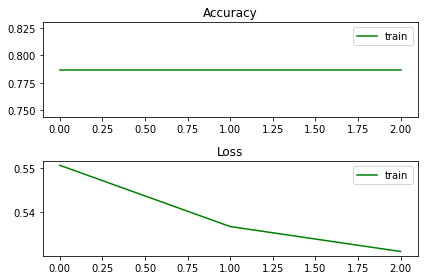

In [ ]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
#plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
#plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [ ]:
# labels
ytest = np.argmax(test_answer_pad, axis=1)

# get predictions
Ytest_ = model.predict([test_story_pad, test_question_pad])
ytest_ = np.argmax(Ytest_, axis=1)

In [ ]:
idx2word = {idx : word for word, idx in word_index.items()}

In [ ]:
print(idx2word)

{1: 'the', 2: 'and', 3: 'to', 4: 'i', 5: 'of', 6: 'her', 7: 'she', 8: 'was', 9: 'a', 10: 'he', 11: 'in', 12: 'that', 13: 'my', 14: 'it', 15: 'is', 16: 'you', 17: 'his', 18: 'me', 19: 'with', 20: 'but', 21: 'not', 22: 'had', 23: 'all', 24: 'for', 25: 'him', 26: 'on', 27: 'there', 28: 's', 29: 'as', 30: 'have', 31: 'at', 32: 'when', 33: 'so', 34: 'be', 35: 'by', 36: 'no', 37: 'this', 38: 'now', 39: 'from', 40: 't', 41: 'would', 42: 'oh', 43: 'out', 44: 'any', 45: 'said', 46: 'will', 47: 'been', 48: 'were', 49: 'what', 50: 'go', 51: 'tears', 52: 'then', 53: 'they', 54: 'down', 55: 'could', 56: 'are', 57: 'we', 58: 'their', 59: 'away', 60: 'never', 61: 'did', 62: 'life', 63: 'if', 64: 'one', 65: 'man', 66: 'love', 67: 'say', 68: 'sad', 69: 'only', 70: 'more', 71: 'like', 72: 'just', 73: 'about', 74: 'can', 75: 'too', 76: 'cry', 77: 'mention', 78: 'saw', 79: 'little', 80: 'very', 81: 'let', 82: 'them', 83: 'into', 84: 'who', 85: 'face', 86: 'time', 87: 'up', 88: 'thought', 89: 'cried', 90: 

In [ ]:
len(test_question_pad)

504

In [ ]:
a=[]
for i in range(len(test_question_pad)):
  l=[]
  for j in range(len(test_question_pad[i])):
    if test_question_pad[i][j]!=0:
      l.append(test_question_pad[i][j])
  a.append(l)

NUM_DISPLAY = len(test_question_pad)

print("{:98}|{:5}|{}".format("질문", "실제값", "예측값"))
print(120 * "-")

n=0
c=1
print(data_total['sentence'][index_test[0]])
predict=[]
sentiment=[]
for i in range(NUM_DISPLAY):
    if n==28:
          print(120 * "-")
          n=0
          print(data['sentence'][index_test[c]])
          c=c+1
    question = " ".join([idx2word[x] for x in a[i]])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:100}: {:7} {}".format(question, label, prediction))
    n=n+1
    predict.append(prediction)
    sentiment.append(label)

질문                                                                                                |실제값  |예측값
------------------------------------------------------------------------------------------------------------------------
the next day was a dreary one for emma  everything seemed to her enveloped in a black atmosphere floating confusedly over the exterior of things  and sorrow was engulfed within her soul with soft shrieks such as the winter wind makes in ruined castles  it was that reverie which we give to things that will not return  the lassitude that seizes you after everything was done  that pain  in fine  that the interruption of every wonted movement  the sudden cessation of any prolonged vibration  brings on  as on the return from vaubyessard  when the quadrilles were running in her head  she was full of a gloomy melancholy  of a numb despair 
is there anything in the text expression phrase that expresses feelings of sadness                  : yes     no
are there any re

In [ ]:
def change(d):
  tmp=[]
  for i in range(len(d)):
    if d[i]=='yes':
      tmp.append(1)
    else:
      tmp.append(0)
  return tmp

In [ ]:
predict_n=change(predict)
sentiment_n=change(sentiment)

In [ ]:
print(predict_n)
print(sentiment_n)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
lnum=int(len(predict_n)/28)

In [ ]:
labeled_real=np.array(sentiment_n).reshape(lnum,28)

In [ ]:
labeled=np.array(predict_n).reshape(lnum,28)
l=pd.DataFrame(labeled)
data_test=data['sentence'][index_test]
data_test=data_test.reset_index()
predict_data=pd.concat([data_test,l],axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error
def rmse(y, y_pred):
  yn_rmse=[]
  for i in range(len(y_pred)):
    RMSE = mean_squared_error(y[i], y_pred[i])**0.5
    yn_rmse.append(RMSE)
  return yn_rmse

rmse_yn=rmse(labeled_real,labeled)
print(rmse_yn)

[0.3779644730092272, 0.4629100498862757, 0.5, 0.5669467095138409, 0.5, 0.5669467095138409, 0.4225771273642583, 0.4225771273642583, 0.4225771273642583, 0.2672612419124244, 0.3779644730092272, 0.4225771273642583, 0.3779644730092272, 0.3779644730092272, 0.4225771273642583, 0.4629100498862757, 0.4225771273642583, 0.5345224838248488]


In [ ]:
predict_data.rename(columns={0: 'y0', 27: 'y27'}, inplace=True)

In [ ]:
data0=predict_data.loc[:,'y0':'y27']
data0=data0.values

susim=[1,1,1,1,0,1,1,1,0,1,0,0,1,1,0,1,1,1,0,0,0,1,1,0,1,0,0,0]
len(susim)
bitan=[1,1,1,1,1,0,1,1,0,0,1,0,1,1,1,0,1,1,0,0,0,1,1,0,1,0,0,0]
len(bitan)
uu=[1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,0,1,0,1,1,1]
len(uu)

susim_m=[]
bitan_m=[]
uu_m=[]
for j in range(len(data0)):
  sum1=0
  sum2=0
  sum3=0
  for i in range(len(susim)):
    score=data0[j][i]*susim[i]
    score2=data0[j][i]*bitan[i]
    score3=data0[j][i]*uu[i]
    sum1+=score
    sum2+=score2
    sum3+=score3
  
  susim_m.append(sum1)
  bitan_m.append(sum2)
  uu_m.append(sum3)

senti=[]
for i in range(len(susim_m)):
  if uu_m[i]>susim_m[i] and uu_m[i]>bitan_m[i]:
    senti.append("우울")
  else:
    if susim_m[i] == bitan_m[i]:
        if uu_m[i]>=1:
          senti.append("수심")
        else:
          senti.append("비탄")
    elif susim_m[i] > bitan_m[i]:
      senti.append("수심")
    else :
      senti.append("비탄")

test_level=pd.DataFrame([senti],index=['pred_level']).transpose()

In [ ]:
data_test_level=data['level'][index_test]

test_sent=np.array(data_test_level)
test_sent=pd.DataFrame([test_sent],index=['level']).transpose()

rmse_yn=np.array(rmse_yn)
rmse_yn=pd.DataFrame([rmse_yn],index=['rmse']).transpose()

In [ ]:
predict_datas=pd.concat([predict_data,rmse_yn,test_level,test_sent],axis=1)

In [ ]:
predict_datas

,index,sentence,y0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,y27,rmse,pred_level,level
0,2,the next day was a dreary one for emma everyt...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.377964,비탄,우울
1,7,but she was eaten up with desires with rage ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.462910,비탄,수심
2,10,the large room was full of people one of the ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500000,비탄,수심
3,16,he came back from france when tom and daisy we...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.566947,비탄,비탄
4,19,the saddest thing under the sun above is to s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500000,비탄,비탄
5,23,is this the real life is this just fantasy cau...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.566947,비탄,우울
6,29,her heart was heavy now as it had never been ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.422577,비탄,우울
7,41,that was a sad day for me a sad day for littl...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.422577,비탄,수심
8,49,poor william said he dear lovely child h...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.422577,비탄,비탄
9,53,but when she was gone i looked about me for a...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.267261,비탄,수심


In [ ]:
predict_dataset=predict_datas.replace('수심',0).replace('비탄',1).replace('우울',2)

In [ ]:
sentiment=predict_dataset['level'].tolist()
predict=predict_dataset['pred_level'].tolist()
import math
sum=0
count=0
for i in range(len(sentiment)):
  if sentiment[i]==predict[i]:
    count=count+1
  sum=sum+(sentiment[i]-predict[i])**2
rmse=math.sqrt(sum/len(sentiment))
print(rmse)
print(len(sentiment),"개 중",count,"개 맞춤")

0.816496580927726
18 개 중 6 개 맞춤
